In [16]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import os

%run ../Scripts/coverage.py
%run ../Scripts/fitness.py
%run ../Scripts/immunity.py
%run ../Scripts/initMethods.py
%run ../Scripts/supMethods.py
%run ../Scripts/mutation.py

In [22]:
params = { #parameters relevant for the equations
    "Nh":             1E8,
    "N0":             1E7, #This Will be updated by self-consitent solution
    "R0":              20, 
    "M":                1, #Also L, total number of spacers
    "mu":          0.0001, #mutation rate
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":             2000, #cross-reactivity kernel
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                   1000,
    "dx":                           1,
    "tf":                        2000,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_mean_nh":          [0,0],
    "conv_size":                 4000,
    "num_threads":                 32,
    "tail_axis":               [1, 1],
}

In [23]:
params, sim_params = init_cond(params, sim_params)

i = 7
foldername = f"../Data/test{i}"
while os.path.exists(foldername):
    i += 1
    foldername = f"../Data/test{i}"

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Phage Population: 10000000.0000| Uc: 2.1449| sigma: 0.5549
Phage Population: 2779.1604| Uc: 0.6784| sigma: 0.4162
Phage Population: 1563.0103| Uc: 0.5221| sigma: 0.3898
Phage Population: 1371.1887| Uc: 0.4833| sigma: 0.3823
Phage Population: 1319.2139| Uc: 0.4715| sigma: 0.3800
Phage Population: 1303.0659| Uc: 0.4678| sigma: 0.3792
Phage Population: 1297.8341| Uc: 0.4665| sigma: 0.3790
Phage Population: 1296.1160| Uc: 0.4661| sigma: 0.3789
Phage Population: 1295.5493| Uc: 0.4660| sigma: 0.3789
Phage Population: 1295.3620| Uc: 0.4658| sigma: 0.3788


In [14]:
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")

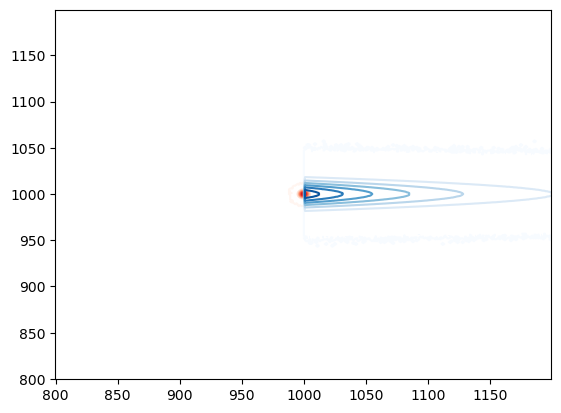

In [15]:
plt.figure()
plt.contour(n.todense(), cmap = "Reds")
plt.contour(nh.todense(), cmap = "Blues")
plt.margins(-0.4, -0.4)
plt.show()

In [20]:
n = init_guassian(params["N"], sim_params, "n")
nh = init_exptail(params["Nh"], params, sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)

for i in range(sim_params["tf"]):
    sparse.save_npz(foldername+f"/sp_frame_n{i}",n.tocoo())
    sparse.save_npz(foldername+f"/sp_frame_nh{i}",nh.tocoo())

    p = elementwise_coverage(nh, n, kernel_quarter, params, sim_params)
    f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = virus_growth(n, f, params, sim_params) #update

    n = mutation(n, params, sim_params)
    nh = immunity_update_split_choice(nh, n, params, sim_params) #update nh

elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:07
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:07
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took 00:00:08
elementwise_coverage took 00:00:08
mutation took 00:00:00
immunity_update_split_choice took

In [21]:
i

1999

In [ ]:
R0_sweep = [20]
kernel = init_quarter_kernel(params, sim_params)
foldername = "test0/"
write2json(foldername, params, sim_params)

for R0 in R0_sweep:
    params["R0"] = R0
    n = init_guassian(params["N"], sim_params, "n")
    nh = init_guassian(params["Nh"], sim_params, "nh")

    for i in range(10000):

        if (i%100 == 0 or i < 20):
            sparse.save_npz(foldername+f"/sp_frame_n{i}",n.tocoo())
            sparse.save_npz(foldername+f"/sp_frame_nh{i}",nh.tocoo())

        p = elementwise_coverage(nh, n, kernel, params, sim_params)
        f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
        # f = norm_fitness(f, n, params, sim_params)
        n = virus_growth(n, f, params, sim_params) #update

        n = mutation(n, params, sim_params)
        nh = immunity_update(nh, n, params, sim_params) #update nh

        if np.sum(n) >= 10*params["Nh"]:
            break